# Example optimisation with stochastic search and gradient descent

## Imports and prep

In [1]:
from ship_routing.core import Route, WayPoint
from ship_routing.data import load_currents, load_winds, load_waves
from ship_routing.convenience import create_route, stochastic_search, gradient_descent

<frozen abc>:106: FutureWarning: xarray subclass HashableDataset should explicitly define __slots__


In [2]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

In [3]:
# parameters

# reproducibility
random_seed = 1234

# data sources
current_data_store = "/Users/wrath/src/git.geomar.de/willi-rath/ship_routing_data/data/cmems_mod_glo_phy_my_0.083deg_P1D-m_time_2021_lat_+10_+65_lon_-100_+010_uo-vo.zarr/"
wave_data_store = "/Users/wrath/src/git.geomar.de/willi-rath/ship_routing_data/data/cmems_mod_glo_wav_my_0.2deg_PT3H-i_time_2021_lat_+10_+65_lon_-100_+010_VHM0-VMDR.zarr/"
wind_data_store = "/Users/wrath/src/git.geomar.de/willi-rath/ship_routing_data/data/cmems_obs-wind_glo_phy_my_l4_0.125deg_PT1H_time_2021_lat_+10_+65_lon_-100_+010_eastward_wind-northward_wind.zarr/"

# initial route
lon_waypoints = [-80.5, -10.0]
lat_waypoints = [30.0, 50.0]
time_start = "2021-08-13T12:00"
time_end = "2021-08-21T12:00"
speed_knots = None  # either one time and speed or both times needed
time_resolution_hours = 6.0

# stochastic search parameters
stoch_number_of_iterations = 400
stoch_acceptance_rate_target = 0.01

# gradient descent parameters
grad_num_iterations = 10
grad_learning_rate_percent_time = 0.5
grad_time_increment = 1_200
grad_learning_rate_percent_along = 0.5
grad_dist_shift_along = 15_000
grad_learning_rate_percent_across = 0.5
grad_dist_shift_across = 15_000

# experiment id
experiment_id = 1

In [4]:
np.random.seed(random_seed)

## Define a route

In [5]:
route_0 = create_route(
    lon_waypoints=lon_waypoints,
    lat_waypoints=lat_waypoints,
    time_start=np.datetime64(time_start),
    speed_knots=16.0,
    time_resolution_hours=time_resolution_hours,
)

route_0

Route(way_points=(WayPoint(lon=np.float64(-80.5), lat=np.float64(30.0), time=np.datetime64('2021-08-13T12:00:00')), WayPoint(lon=-79.139109120998, lat=31.0660194892236, time=np.datetime64('2021-08-13T17:56:38.057')), WayPoint(lon=-77.74773455145981, lat=32.11718478868122, time=np.datetime64('2021-08-13T23:53:16.114')), WayPoint(lon=-76.32434269596945, lat=33.15253762198593, time=np.datetime64('2021-08-14T05:49:54.171')), WayPoint(lon=-74.86738735157664, lat=34.17107009771546, time=np.datetime64('2021-08-14T11:46:32.228')), WayPoint(lon=-73.37531802844259, lat=35.171722599509195, time=np.datetime64('2021-08-14T17:43:10.285')), WayPoint(lon=-71.84659012535298, lat=36.15338189535891, time=np.datetime64('2021-08-14T23:39:48.342')), WayPoint(lon=-70.27967718012803, lat=37.11487954484631, time=np.datetime64('2021-08-15T05:36:26.399')), WayPoint(lon=-68.67308541317253, lat=38.054990696475144, time=np.datetime64('2021-08-15T11:33:04.457')), WayPoint(lon=-67.02537077033455, lat=38.9724333813612

In [6]:
print("speed (m/s)", np.mean([l.speed_ms for l in route_0.legs]))

speed (m/s) 8.23111900896213


## Load and plot currents, winds, waves

In [7]:
currents = load_currents(
    data_file=current_data_store,
    engine="zarr",
    chunks="auto",
)
currents["speed"] = ((currents.to_array() ** 2).sum("variable") ** 0.5).where(
    ~currents.uo.isnull()
)

currents

<xarray.HashableDataset> Size: 4GB
Dimensions:  (lat: 661, lon: 1321, time: 365)
Coordinates:
    depth    float32 4B ...
  * lat      (lat) float32 3kB 10.0 10.08 10.17 10.25 ... 64.75 64.83 64.92 65.0
  * lon      (lon) float32 5kB -100.0 -99.92 -99.83 -99.75 ... 9.833 9.917 10.0
  * time     (time) datetime64[ns] 3kB 2021-01-01 2021-01-02 ... 2021-12-31
Data variables:
    uo       (time, lat, lon) float32 1GB dask.array<chunksize=(38, 661, 1321), meta=np.ndarray>
    vo       (time, lat, lon) float32 1GB dask.array<chunksize=(38, 661, 1321), meta=np.ndarray>
    speed    (time, lat, lon) float32 1GB dask.array<chunksize=(38, 661, 1321), meta=np.ndarray>

In [8]:
winds = load_winds(
    data_file=wind_data_store,
    engine="zarr",
    chunks="auto",
)
winds["speed"] = ((winds.to_array() ** 2).sum("variable") ** 0.5).where(
    ~winds.uw.isnull()
)
winds

/Users/wrath/src/github.com/willirath/ship_routing/src/ship_routing/data.py:52: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 107. This could degrade performance. Instead, consider rechunking after loading.
  ds = xr.open_dataset(data_file, **kwargs)
/Users/wrath/src/github.com/willirath/ship_routing/src/ship_routing/data.py:52: UserWarning: The specified chunks separate the stored chunks along dimension "latitude" starting at index 395. This could degrade performance. Instead, consider rechunking after loading.
  ds = xr.open_dataset(data_file, **kwargs)
/Users/wrath/src/github.com/willirath/ship_routing/src/ship_routing/data.py:52: UserWarning: The specified chunks separate the stored chunks along dimension "longitude" starting at index 791. This could degrade performance. Instead, consider rechunking after loading.
  ds = xr.open_dataset(data_file, **kwargs)


<xarray.HashableDataset> Size: 41GB
Dimensions:  (time: 8760, lat: 440, lon: 880)
Coordinates:
  * lat      (lat) float32 2kB 10.06 10.19 10.31 10.44 ... 64.69 64.81 64.94
  * lon      (lon) float32 4kB -99.94 -99.81 -99.69 -99.56 ... 9.688 9.812 9.938
  * time     (time) datetime64[ns] 70kB 2021-01-01 ... 2021-12-31T23:00:00
Data variables:
    uw       (time, lat, lon) float32 14GB dask.array<chunksize=(107, 395, 791), meta=np.ndarray>
    vw       (time, lat, lon) float32 14GB dask.array<chunksize=(107, 395, 791), meta=np.ndarray>
    speed    (time, lat, lon) float32 14GB dask.array<chunksize=(107, 395, 791), meta=np.ndarray>

In [9]:
waves = load_waves(
    data_file=wave_data_store,
    engine="zarr",
    chunks="auto",
)

waves

<xarray.HashableDataset> Size: 4GB
Dimensions:  (time: 2920, lat: 276, lon: 551)
Coordinates:
  * lat      (lat) float32 1kB 10.0 10.2 10.4 10.6 10.8 ... 64.4 64.6 64.8 65.0
  * lon      (lon) float32 2kB -100.0 -99.8 -99.6 -99.4 ... 9.4 9.6 9.8 10.0
  * time     (time) datetime64[ns] 23kB 2021-01-01 ... 2021-12-31T21:00:00
Data variables:
    wh       (time, lat, lon) float32 2GB dask.array<chunksize=(200, 276, 551), meta=np.ndarray>
    VMDR     (time, lat, lon) float32 2GB dask.array<chunksize=(200, 276, 551), meta=np.ndarray>

## Subset for the route

In [10]:
%time currents = currents.sel(time=slice(route_0.way_points[0].time, route_0.way_points[-1].time)).compute()
%time winds = winds.sel(time=slice(route_0.way_points[0].time, route_0.way_points[-1].time)).compute()
%time waves = waves.sel(time=slice(route_0.way_points[0].time, route_0.way_points[-1].time)).compute()

CPU times: user 732 ms, sys: 431 ms, total: 1.16 s
Wall time: 645 ms
CPU times: user 7.03 s, sys: 2.88 s, total: 9.91 s
Wall time: 1.35 s
CPU times: user 90.9 ms, sys: 22.9 ms, total: 114 ms
Wall time: 45.9 ms


## Stochastic Local Search (in route space)

In [11]:
route_1, logs_routes = stochastic_search(
    route=route_0,
    number_of_iterations=stoch_number_of_iterations,
    acceptance_rate_target=stoch_acceptance_rate_target,
    mod_width=0.75 * route_0.length_meters,
    max_move_meters=0.75**0.5 * route_0.length_meters,
    current_data_set=currents,
    wave_data_set=waves,
    wind_data_set=winds,
)

100%|█████████████████████████████████████████| 400/400 [01:50<00:00,  3.63it/s]


## Gradient descents

In [12]:
route_2, _logs = gradient_descent(
    route=route_1,
    num_iterations=grad_num_iterations,
    learning_rate_percent_time=grad_learning_rate_percent_time,
    time_increment=grad_time_increment,
    learning_rate_percent_along=grad_learning_rate_percent_along,
    dist_shift_along=grad_dist_shift_along,
    learning_rate_percent_across=grad_learning_rate_percent_across,
    dist_shift_across=grad_dist_shift_across,
    include_logs_routes=True,
    current_data_set=currents,
    wave_data_set=waves,
    wind_data_set=winds,
)
logs_routes.extend(_logs)

100%|███████████████████████████████████████████| 10/10 [01:02<00:00,  6.21s/it]


/var/folders/w1/m9mm9h9167z_gcfzfffr0rgsh6j6kj/T/ipykernel_7433/395985238.py:2: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pd.concat([lr.logs.data_frame for lr in logs_routes], ignore_index=True)["cost"].plot(


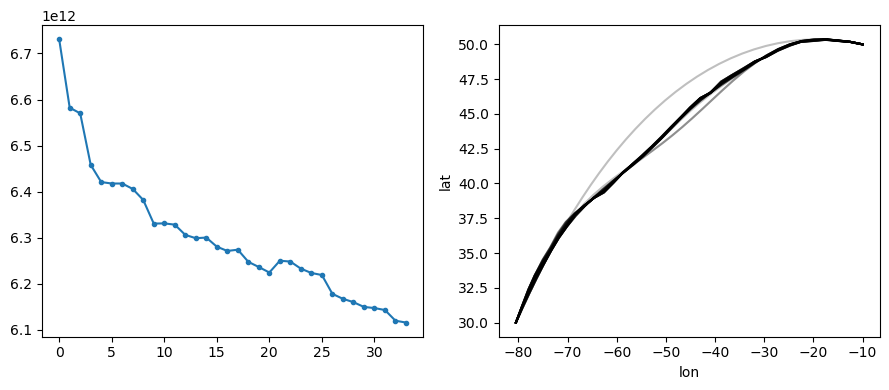

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4))
pd.concat([lr.logs.data_frame for lr in logs_routes], ignore_index=True)["cost"].plot(
    ax=ax[0], marker="."
)
for lr in logs_routes:
    ax[1].plot(lr.route.data_frame["lon"], lr.route.data_frame["lat"], "k-", alpha=0.25)
    ax[1].set_xlabel("lon")
    ax[1].set_ylabel("lat")
fig.tight_layout();

/var/folders/w1/m9mm9h9167z_gcfzfffr0rgsh6j6kj/T/ipykernel_7433/2811698609.py:43: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.tight_layout();


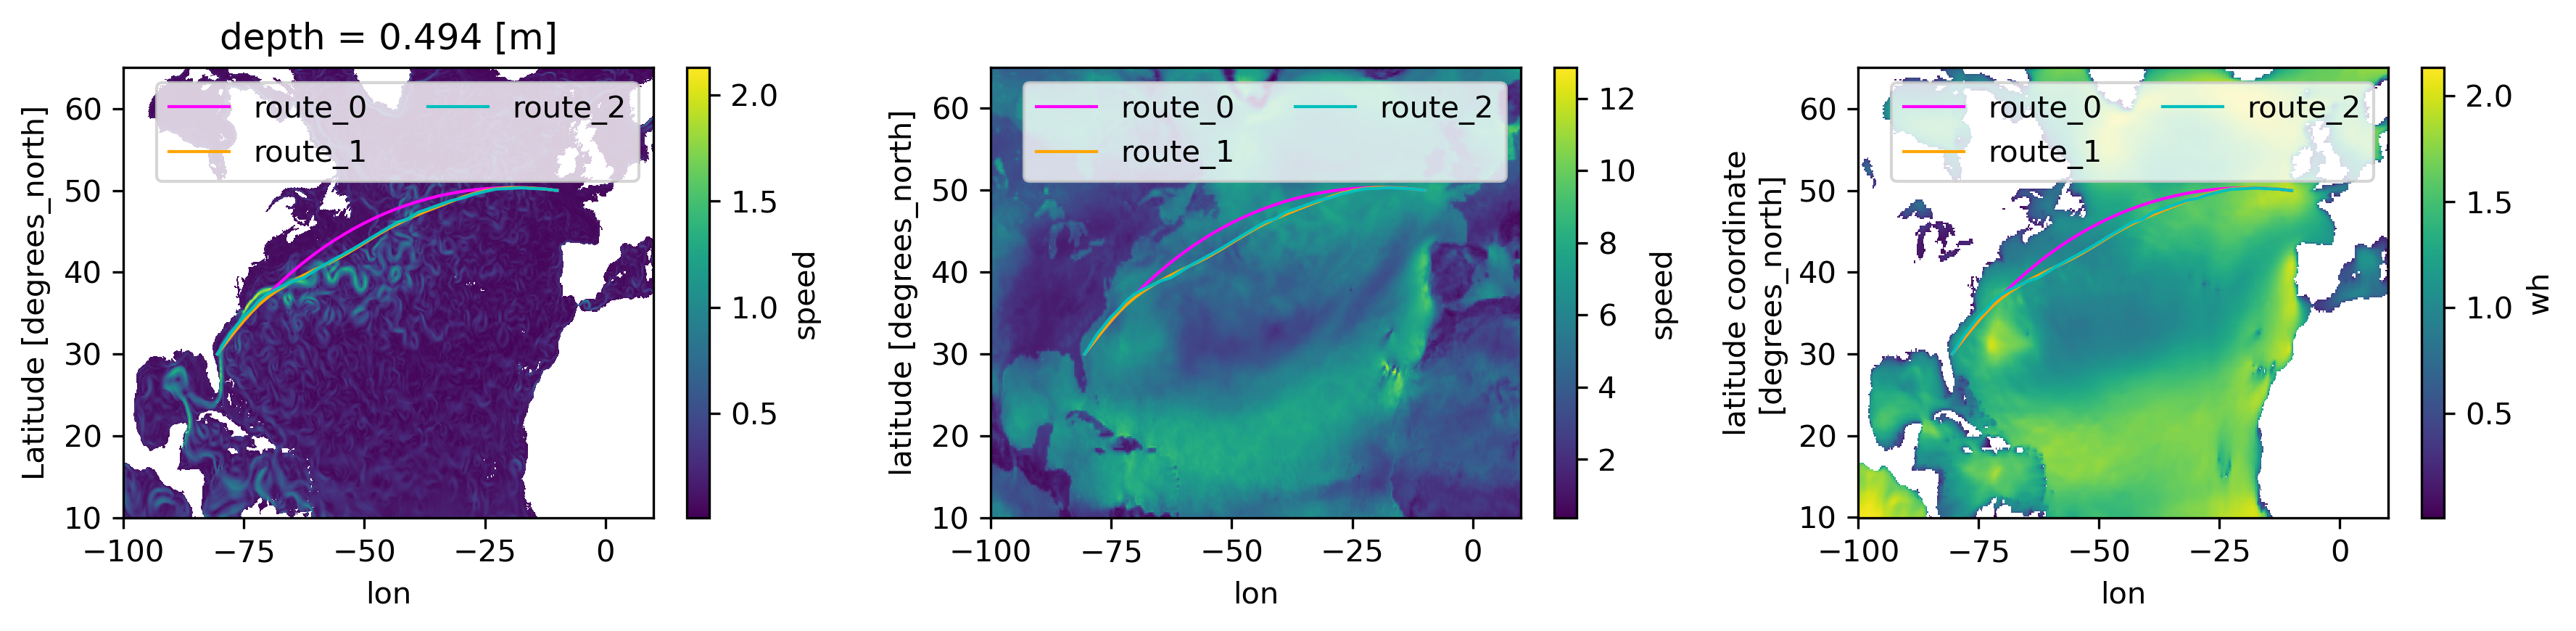

In [14]:
fig, ax = plt.subplots(
    1,
    3,
    figsize=(12, 3),
)

fig.set_dpi(300)

currents.speed.mean("time").plot(ax=ax.flatten()[0])
winds.speed.mean("time").plot(ax=ax.flatten()[1])
waves.wh.mean("time").plot(ax=ax.flatten()[2])

for _ax in ax.flatten():
    route_0.data_frame.plot.line(
        x="lon",
        y="lat",
        markersize=2.5,
        color="magenta",
        ax=_ax,
        label="route_0",
        linewidth=1.0,
    )
    route_1.data_frame.plot.line(
        x="lon",
        y="lat",
        markersize=2.5,
        color="orange",
        ax=_ax,
        label="route_1",
        linewidth=1.0,
    )
    route_2.data_frame.plot.line(
        x="lon",
        y="lat",
        markersize=2.5,
        color="c",
        ax=_ax,
        label="route_2",
        linewidth=1.0,
    )
    _ax.legend(ncol=2)

fig.tight_layout();

In [20]:
df = pd.concat([lr.logs.data_frame for lr in logs_routes], ignore_index=True)
df.head()

/var/folders/w1/m9mm9h9167z_gcfzfffr0rgsh6j6kj/T/ipykernel_7433/783450037.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([lr.logs.data_frame for lr in logs_routes], ignore_index=True)


,iteration,cost,stoch_acceptance_rate_target,stoch_acceptance_rate_for_increase_cost,stoch_refinement_factor,stoch_mod_width,stoch_max_move_meters,grad_learning_rate_percent_time,grad_time_increment,grad_learning_rate_percent_along,grad_dist_shift_along,grad_learning_rate_percent_across,grad_dist_shift_across,method
0,0,6.730588e+12,0.01,0.0,0.5,4.623411e+06,5.338656e+06,NaN,None,NaN,None,NaN,None,stochastic_search_initial
1,30,6.582329e+12,0.01,0.0,0.5,4.623411e+06,5.338656e+06,NaN,None,NaN,None,NaN,None,stochastic_search
2,252,6.569983e+12,0.01,0.0,0.5,2.311706e+06,2.669328e+06,NaN,None,NaN,None,NaN,None,stochastic_search
3,267,6.458199e+12,0.01,0.0,0.5,2.311706e+06,2.669328e+06,NaN,None,NaN,None,NaN,None,stochastic_search
4,274,6.420907e+12,0.01,0.0,0.5,2.311706e+06,2.669328e+06,NaN,None,NaN,None,NaN,None,stochastic_search


Text(0.5, 0, 'step')

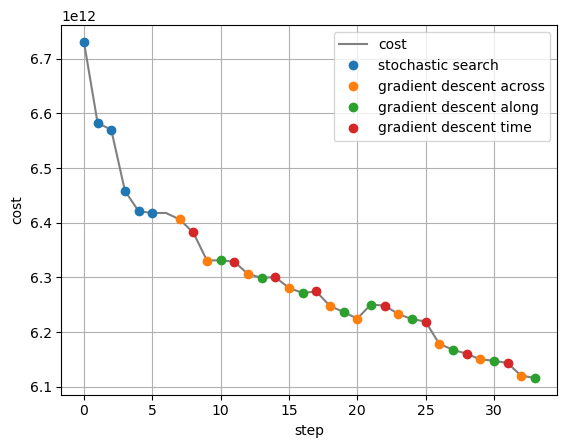

In [21]:
ax = df.cost.plot(color="gray", label="cost")
df.where(df.method.str.contains("stoch")).dropna(how="all").cost.plot(
    ax=ax, label="stochastic search", marker="o", linewidth=0
)
df.where(df.method.str.contains("across")).dropna(how="all").cost.plot(
    ax=ax, label="gradient descent across", marker="o", linewidth=0
)
df.where(df.method.str.contains("along")).dropna(how="all").cost.plot(
    ax=ax, label="gradient descent along", marker="o", linewidth=0
)
df.where(df.method.str.contains("time")).dropna(how="all").cost.plot(
    ax=ax, label="gradient descent time", marker="o", linewidth=0
)
ax.legend()
ax.grid()
ax.set_ylabel("cost")
ax.set_xlabel("step")

## Save results

In [16]:
!mkdir -p runs

In [17]:
import jsonpickle

with open(f"runs/run_{experiment_id:04d}.json", "w+") as f:
    f.write(jsonpickle.encode(logs_routes))